# Comparing GraphSAGE to CASC

## Introduction

Hamilton et al. developed [GraphSAGE](http://snap.stanford.edu/graphsage/) to generate low-dimensional embeddings for nodes in large network. Unlike previous transductive method, GraphSAGE excels at generate embeddings for previously unseen nodes and graphs by leveraging node attribute information.

On the other hand, Binkiewicz et al. developed [Covariate-assisted Spectral Clustering(CASC)](https://academic.oup.com/biomet/article/104/2/361/3074977) with a similar goal: use node covariates like node locations or neurological region memberships to help generate embeddings and identify latent communities in the graph.

Since both methods utilize additional node information other than node connection to generate latent representations, it will be interesting to compare the two methods and observe their performance on various datasets.

## CORA Dataset

The Cora dataset is the MNIST equivalent for graph learning and is often used for first testing purposes. It consists of 2708 scientific publications classified into one of seven classes. The citation network consists of 5429 links. Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary. The dictionary consists of 1433 unique words.

In [1]:
import os
import networkx as nx
import pandas as pd
import graspologic
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


### Load the CORA Dataset

A is the $2708*2708$ adjacency matrix, X is the $2708*1433$ covariate matrix, and node_subjects is a $2708*1$ vector storing the category for each node. G_SAGE is the combination of A and X used for the Stellar GraphSAGE implementation.

In [2]:
data_dir = os.path.expanduser("~/Documents/Neural Data Design/cora")
edgelist = pd.read_csv(os.path.join(data_dir, "cora.cites"), sep='\t', header=None, names=["target", "source"])
edgelist["label"] = "cites"
G_CASC = nx.from_pandas_edgelist(edgelist, edge_attr="label")
nx.set_node_attributes(G_CASC, "paper", "label")

In [3]:
feature_names = ["w_{}".format(ii) for ii in range(1433)]
column_names =  feature_names + ["subject"]
node_data = pd.read_csv(os.path.join(data_dir, "cora.content"), sep='\t', header=None, names=column_names)
X = node_data.to_numpy()[:, 0:1433]
A = graspologic.utils.import_graph(G_CASC)
A = graspologic.utils.pass_to_ranks(A)
node_subjects_CASC = pd.Series(node_data["subject"].to_numpy())


AttributeError: module 'graspologic.utils' has no attribute 'pass_to_rank'

In [5]:
from stellargraph import datasets

dataset = datasets.Cora()
G_SAGE, node_subjects_SAGE = dataset.load()

### Search in alpha and n_components for CASC

We need to search in the parameter space of these two variables to determine an optimal combination for CASC.


Text(0.5, 0, 'accuracy')

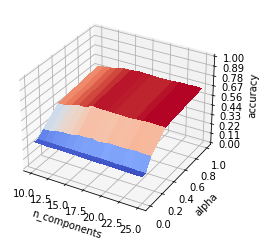

In [7]:
%matplotlib inline
from tensorflow.keras import layers, optimizers, losses, metrics, Model, Sequential, utils
from graspologic.embed import CovariateAssistedEmbed as CASE
from sklearn import preprocessing, model_selection
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator


# Split the dataset into training and testing
train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects_CASC, train_size=0.1, test_size=None, stratify=node_subjects_CASC
)

target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_subjects)
test_targets = target_encoding.transform(test_subjects)

# Define the search range
alpha_min=10e-5
alpha_max=1
alpha_num=10
components_min=10
components_max=25

components_num = components_max - components_min + 1
alpha_range = np.geomspace(alpha_min, alpha_max, alpha_num)
components_range = range(components_min, components_max+1)

test_loss = np.zeros((alpha_num, components_num))
test_acc = np.zeros((alpha_num, components_num))

for a, i in zip(alpha_range, range(0, alpha_num)):
    for n, j in zip(components_range, range(0, components_num)):
        case = CASE(alpha=a, assortative=True, n_components=n)
        latents = case.fit_transform((A, X))
        train_data = latents[train_subjects.index.values, :]
        test_data = latents[test_subjects.index.values, :]
        model = Sequential(
            layers.Dense(units=train_targets.shape[1], activation="softmax")
        )
        model.compile(
            optimizer=optimizers.Adam(lr=0.03),
            loss=losses.categorical_crossentropy,
            metrics=["acc"],
        )
        model.fit(train_data, train_targets, epochs=50, verbose=0)
        test_loss[i, j], test_acc[i, j] = model.evaluate(test_data,  test_targets,                  verbose=0)

components_range, alpha_range = np.meshgrid(components_range, alpha_range)
fig = plt.figure()
ax = plt.axes(projection='3d')

surf = ax.plot_surface(components_range, alpha_range, test_acc, cmap=cm.coolwarm,               linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(0, 1)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

ax.set_xlabel('n_components')
ax.set_ylabel('alpha')
ax.set_zlabel('accuracy')

Based on the search, we can safely says that a combination of alpha=1 and n_components=25 will give us the optimal performance for CASC

### K-Fold Validation for GraphSAGE and CASC

In [31]:
from stellargraph.mapper import GraphSAGENodeGenerator
from stellargraph.layer import GraphSAGE

num_folds = 10
# The first column corresponds to GraphSAGE, the second column corresponds to CASC
acc_per_fold = np.zeros((num_folds, 2))
loss_per_fold = np.zeros((num_folds, 2))

# Parameters specific for GraphSAGE
batch_size = 50
num_samples = [10, 5]  
generator = GraphSAGENodeGenerator(G_SAGE, batch_size, num_samples)

# Parameters specific for CASC
alpha = 1
n_components = 25

# Calculate latent positions for CASC
case = CASE(alpha=alpha, assortative=False, n_components=n_components)
latents = case.fit_transform((A, X))

skf = model_selection.StratifiedKFold(n_splits=num_folds)

fold_no = 1
for train_index, test_index in skf.split(np.zeros(2708), node_subjects_CASC):

    # GraphSAGE

    # Separate the dataset into training and testing
    train_subjects = node_subjects_SAGE.iloc[train_index]
    test_subjects = node_subjects_SAGE.iloc[test_index]

    # Convert the labels into one-hot vectors
    target_encoding = preprocessing.LabelBinarizer()
    train_targets = target_encoding.fit_transform(train_subjects)
    test_targets = target_encoding.transform(test_subjects)

    train_gen = generator.flow(train_subjects.index, train_targets, shuffle=True)

    graphsage_model = GraphSAGE(
        layer_sizes=[32, 32], generator=generator, bias=True, dropout=0.5,
    )

    x_inp, x_out = graphsage_model.in_out_tensors()
    prediction = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

    model = Model(inputs=x_inp, outputs=prediction)
    model.compile(
        optimizer=optimizers.Adam(lr=0.005),
        loss=losses.categorical_crossentropy,
        metrics=["acc"],
    )
    model.fit(train_gen, epochs=20, verbose=0, shuffle=False)
    test_gen = generator.flow(test_subjects.index, test_targets)
    test_loss, test_acc = model.evaluate(test_gen, verbose=0)
    print(f'GraphSAGE: Score for fold {fold_no}: {model.metrics_names[0]} of {test_loss}; {model.metrics_names[1]} of {test_acc}')
    acc_per_fold[fold_no-1, 0] = test_acc
    loss_per_fold[fold_no-1, 0] = test_loss

    # CASC
    train_data = latents[train_index, :]
    test_data = latents[test_index, :]

    model = Sequential(
        layers.Dense(units=train_targets.shape[1], activation="softmax")
    )
    model.compile(
        optimizer=optimizers.Adam(lr=0.03),
        loss=losses.categorical_crossentropy,
        metrics=["acc"],
    )
    model.fit(train_data, train_targets, epochs=80, verbose=0)
    test_loss, test_acc = model.evaluate(test_data,  test_targets, verbose=0)

    print(f'CASC: Score for fold {fold_no}: {model.metrics_names[0]} of {test_loss}; {model.metrics_names[1]} of {test_acc}')
    acc_per_fold[fold_no-1, 1] = test_acc
    loss_per_fold[fold_no-1, 1] = test_loss

    # Increase fold number
    fold_no = fold_no + 1

    print()

GraphSAGE: Score for fold 1: loss of 0.5059147477149963; acc of 0.8819188475608826
CASC: Score for fold 1: loss of 0.8854701519012451; acc of 0.7638376355171204

GraphSAGE: Score for fold 2: loss of 0.548446774482727; acc of 0.8597785830497742
CASC: Score for fold 2: loss of 0.7997560501098633; acc of 0.7269372940063477

GraphSAGE: Score for fold 3: loss of 0.3743210434913635; acc of 0.8819188475608826
CASC: Score for fold 3: loss of 0.7256977558135986; acc of 0.7712177038192749

GraphSAGE: Score for fold 4: loss of 0.5451735854148865; acc of 0.8634686470031738
CASC: Score for fold 4: loss of 0.7485193014144897; acc of 0.7306272983551025

GraphSAGE: Score for fold 5: loss of 0.5657549500465393; acc of 0.8265682458877563
CASC: Score for fold 5: loss of 0.8359146118164062; acc of 0.7453874349594116

GraphSAGE: Score for fold 6: loss of 0.49620258808135986; acc of 0.8708487153053284
CASC: Score for fold 6: loss of 0.8750122785568237; acc of 0.6900368928909302

GraphSAGE: Score for fold 7:

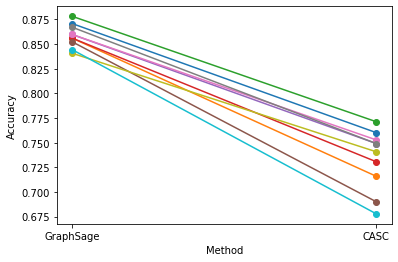

In [18]:
ax = plt.gca()
for i in range(0, 10):
    plt.plot([1, 2], [acc_per_fold[i, 0], acc_per_fold[i, 1]], marker='o')
ax.set_xlabel('Method')
ax.set_ylabel('Accuracy')
ax.set_xticks([1, 2])
ax.set_xticklabels(['GraphSage', 'CASC']);

### GraphSAGE Confusion Matrix

In [29]:
#collapse
train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects_SAGE, train_size=0.1, test_size=None, stratify=node_subjects_SAGE
)

target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_subjects)
test_targets = target_encoding.transform(test_subjects)

generator = GraphSAGENodeGenerator(G_SAGE, batch_size, num_samples)

train_gen = generator.flow(train_subjects.index, train_targets, shuffle=True)

graphsage_model = GraphSAGE(
    layer_sizes=[32, 32], generator=generator, bias=True, dropout=0.5,
)

x_inp, x_out = graphsage_model.in_out_tensors()
prediction = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

model = Model(inputs=x_inp, outputs=prediction)
model.compile(
    optimizer=optimizers.Adam(lr=0.005),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)
model.fit(train_gen, epochs=20, verbose=0, shuffle=False)

all_nodes = node_subjects_SAGE.index
all_mapper = generator.flow(all_nodes)
all_predictions = model.predict(all_mapper)
node_predictions = target_encoding.inverse_transform(all_predictions)

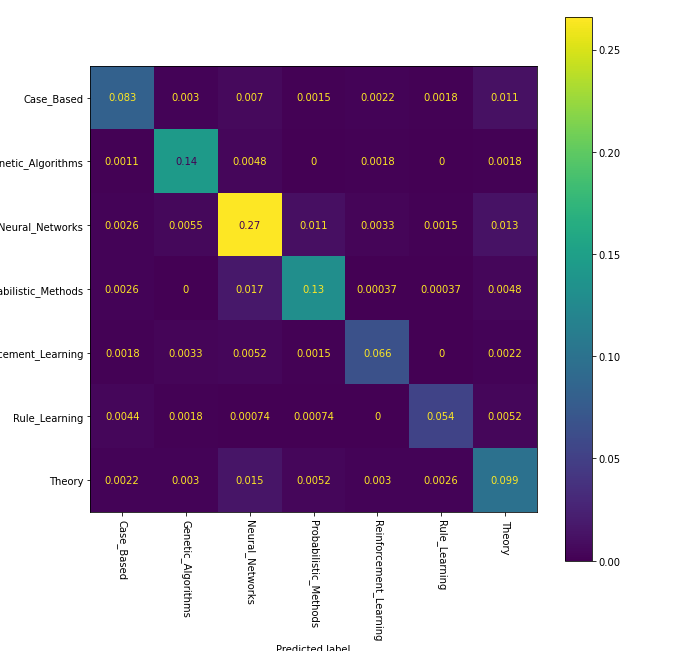

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

figure, ax = plt.subplots(figsize=(10, 10))
cm = confusion_matrix(node_subjects_SAGE, node_predictions, labels=['Case_Based', 'Genetic_Algorithms', 'Neural_Networks',
       'Probabilistic_Methods', 'Reinforcement_Learning', 'Rule_Learning',
       'Theory'], normalize='all')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Case_Based', 'Genetic_Algorithms', 'Neural_Networks',
       'Probabilistic_Methods', 'Reinforcement_Learning', 'Rule_Learning',
       'Theory'])
disp.plot(ax=ax, xticks_rotation=270)

### CASC Confusion Matrix

In [20]:
#collapse
train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects_CASC, train_size=0.1, test_size=None, stratify=node_subjects_CASC
)

target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_subjects)
test_targets = target_encoding.transform(test_subjects)

train_data = latents[train_subjects.index.values, :]
test_data = latents[test_subjects.index.values, :]

model = Sequential(
    layers.Dense(units=train_targets.shape[1], activation="softmax")
)

model.compile(
    optimizer=optimizers.Adam(lr=0.03),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

model.fit(train_data, train_targets, epochs=50, verbose=0)

all_predictions = model.predict(latents)
node_predictions = target_encoding.inverse_transform(all_predictions)

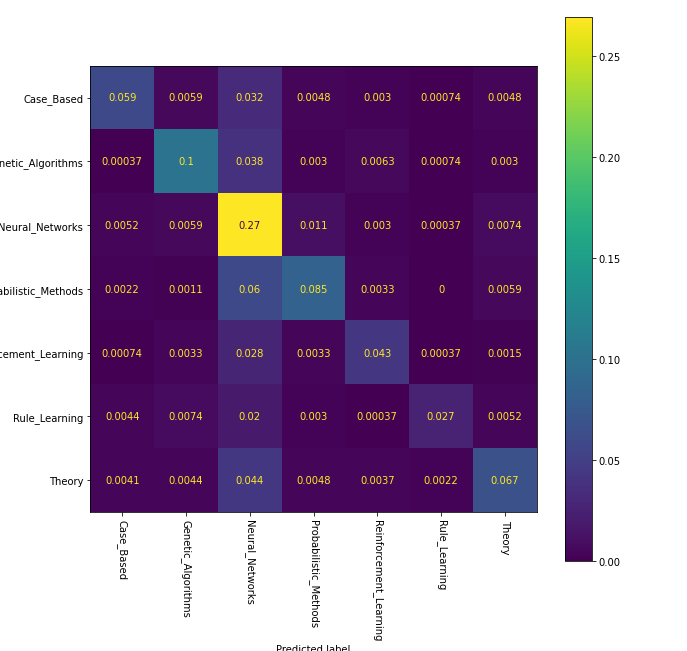

In [26]:
figure, ax = plt.subplots(figsize=(10, 10))
cm = confusion_matrix(node_subjects_CASC, node_predictions, labels=['Case_Based', 'Genetic_Algorithms', 'Neural_Networks',
       'Probabilistic_Methods', 'Reinforcement_Learning', 'Rule_Learning',
       'Theory'], normalize='all')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Case_Based', 'Genetic_Algorithms', 'Neural_Networks',
       'Probabilistic_Methods', 'Reinforcement_Learning', 'Rule_Learning',
       'Theory'])
disp.plot(ax=ax, xticks_rotation=270)